In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicySimulator, createEnv
from DiffusionLibs import DiffusionPolicyInterface
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 4
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="test", type="data")

Environment Configuration
Number of Users:        8
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              200
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.012
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [ ]:
num_windows = 1000
N_episodes = 10
obvMode = "predicted" # "perfect" or "predicted"
sample_method = "EAS"
mode = "test"
type = "data"

# ========= Evaluate MDP ============
if configIdx in [0,1,2,3]:
    with open(f'Results/MdpPolicy/mdpKernelParams_config{0}.pkl', 'rb') as f:
        mdpKernelParams = pickle.load(f)
    mdpPolicy = MdpKernel()
    mdpPolicy.load_policy(mdpKernelParams, policyMode="deterministic", randomR=False)
    # ==== Evaluate MDP Policy====
    policySimulator = PolicySimulator(env)
    policySimulator.setupModes(obvMode=obvMode, mode=mode, type=type)
    policySimulator.loadPolicies([mdpPolicy], [[0,1,2,3]])
    simResultMdp = policySimulator.runSimulation(num_windows=num_windows, N_episodes=N_episodes) 
if configIdx in [4,5,6,7]:
    with open(f'Results/MdpPolicy/mdpKernelParams_config{0}.pkl', 'rb') as f:
        mdpKernelParams = pickle.load(f)
    mdpPolicy = MdpKernel()
    mdpPolicy.load_policy(mdpKernelParams, policyMode="deterministic", randomR=False)
    # ==== Evaluate MDP Policy====
    policySimulator = PolicySimulator(env)
    policySimulator.setupModes(obvMode=obvMode, mode=mode, type=type)
    policySimulator.loadPolicies([mdpPolicy, mdpPolicy], [[0,1,2,3], [4,5,6,7]])
    simResultMdp = policySimulator.runSimulation(num_windows=num_windows, N_episodes=N_episodes) 

# ==== Evaluate DiffusionQ Policy
with open(f'Results/DiffusionQ/diffusionQ_params_config{configIdx}.pkl', 'rb') as f:
    diffusionQParams = pickle.load(f)
print(diffusionQParams)
diffusionPolicyInterface = DiffusionPolicyInterface(envParams, **diffusionQParams)
model_state_dict = torch.load(f'Results/DiffusionQ/diffusionQ_config{configIdx}.pth')
diffusionPolicyInterface.diffusionQ.load_state_dict(model_state_dict)
diffusionPolicyInterface.diffusionQ.eval()
evalResult = diffusionPolicyInterface.eval(env, num_windows=num_windows, obvMode=obvMode, mode=mode, type=type, sample_method=sample_method)



Simulation Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Avg Reward MDP: 0.003617994205486129
Avg Reward DiffusionQ: 0.004950032979422646


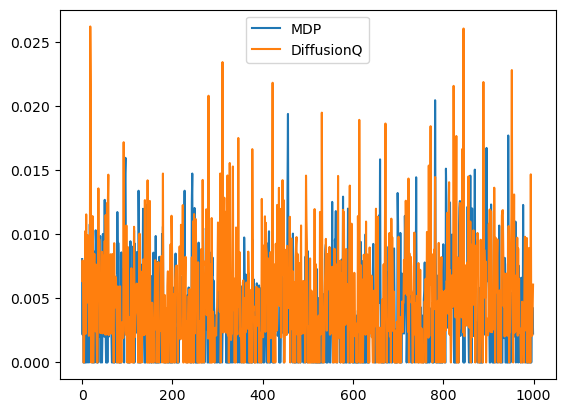

In [5]:
rewardRecord_mdp = simResultMdp['rewardRecord']
rewardRecord_diffusionQ = evalResult['rewardRecord']
print(f"Avg Reward MDP: {np.mean(rewardRecord_mdp)}")
print(f"Avg Reward DiffusionQ: {np.mean(rewardRecord_diffusionQ)}")

plt.plot(rewardRecord_mdp, label='MDP')
plt.plot(rewardRecord_diffusionQ, label='DiffusionQ')
plt.legend()
plt.show()  

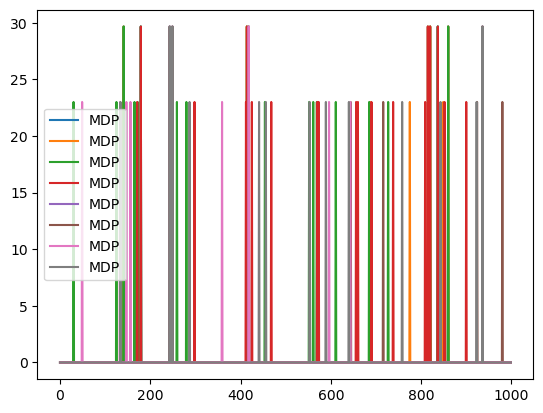

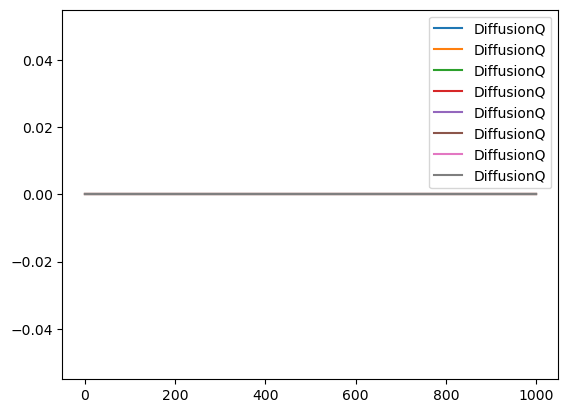

In [7]:
action_mdp = np.array([w*r for w, r, M, alpha in simResultMdp['actionsRecord']])
action_diffusionQ = np.array([w*r for w, r, M, alpha in evalResult['actionsRecord']])
plt.plot(action_mdp, label='MDP')
plt.legend()
plt.show()
plt.plot(action_diffusionQ, label='DiffusionQ')
plt.legend()
plt.show()

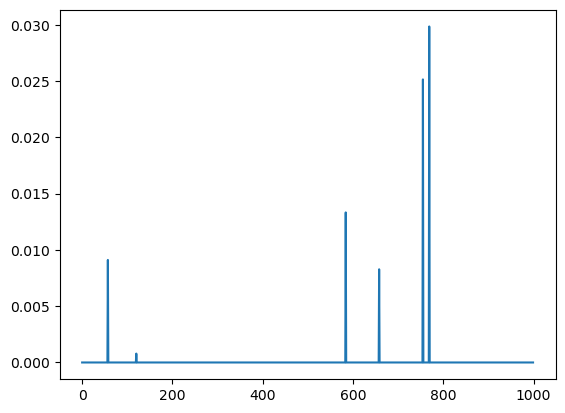

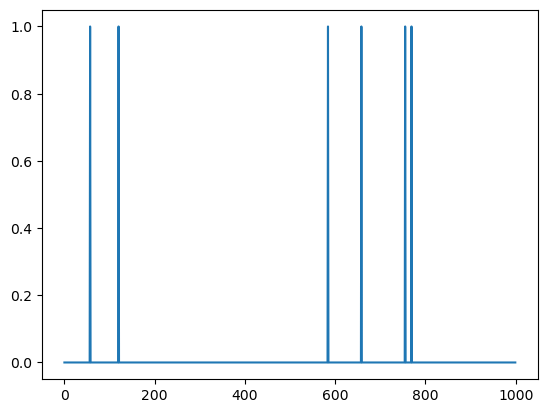

In [ ]:
def check_constraint_violation(action, bandwidth):
    w, r, _, alpha = zip(*action)
    w, r, alpha = np.array(w), np.array(r), np.array(alpha)
    cost = np.sum(w * r, axis=1)
    excess  = cost - alpha * bandwidth
    penalty = (np.maximum(excess, 0.0)/bandwidth)**2
    violate = excess > 0.0
    return penalty, violate

penalty, violate = check_constraint_violation(evalResult['actionsRecord'], envParams['B'])
plt.plot(penalty)
plt.show()
plt.plot(violate)
plt.show()

In [ ]:
import torch

s = [100,100,100,100]
for i in range(10):
    a = diffusionPolicyInterface.sample(s, N_action_candidates=50, sample_method="greedy")
    (w, r, M, alpha) = a
    print(w)




[0 0 0 0]
[0 0 0 0]
[0 0 1 0]
[0 0 0 1]
[1 1 1 0]
[0 0 0 0]
[0 1 1 0]
[0 0 0 0]
[1 1 1 0]
[0 0 0 1]
